In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, '../tools/')

from tools import * 

In [2]:
config = pd.Series({
    'path': os.path.abspath('../dades'),
    'file_type':'csv',
    'years':[2019],
    'dataset': 'BicingNou_ESTACIONS_CLEAN'
})


In [3]:
client = Client()
client

<Client: 'tcp://127.0.0.1:35439' processes=4 threads=16, memory=16.44 GB>

# Read data

In [4]:
%%time

data = read_dask_dataframes(config.path, config.file_type, config.dataset, config.years)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 242 ms, sys: 14.7 ms, total: 257 ms
Wall time: 249 ms


# config_year.year 

In [5]:
config_year = pd.Series({
    'path':config.path,
    'file_type':config.file_type,
    'year':2019,
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [6]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [7]:
first_size = get_ddf_shape(data[config_year.year])

# Visualization 2019

In [8]:
%%time

data[config_year.year] = load_checkpoint(config_year)

# checkpoint reloaded.

checkpoint reloaded.
CPU times: user 12.5 ms, sys: 0 ns, total: 12.5 ms
Wall time: 11.6 ms


In [9]:
%%time

last_size = get_ddf_shape(data[config_year.year])

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(last_size[0]-first_size[0]):02d} rows')
print(f'dropped {(last_size[1]-first_size[1]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed -94407 rows
dropped -3 columns
CPU times: user 205 ms, sys: 0 ns, total: 205 ms
Wall time: 1.55 s


In [10]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [11]:
%%time

nans = get_features_nans(data[config_year.year])

zeros = get_features_zero(data[config_year.year])

CPU times: user 810 ms, sys: 0 ns, total: 810 ms
Wall time: 5.86 s


In [12]:
nans

{}

In [13]:
zeros

{'num_docks_available': 2.1196582372960866,
 'num_bikes_available': 16.149311430790817,
 'status': 87.09595466485675,
 'is_installed': 0.007369283393104817,
 'is_renting': 0.06689703562690093,
 'is_returning': 0.06663896733687003,
 'num_bikes_available_types.mechanical': 19.54715323435554,
 'num_bikes_available_types.ebike': 55.86042978693022,
 'dayofweek': 14.588686458210573,
 'hour': 4.254456480940654,
 'ctx0': 2.1196582372960866,
 'ctx1': 2.11515637934777,
 'ctx2': 2.1099376650382555,
 'ctx3': 2.1041167913853362,
 'ctx4': 2.0982672434779692}

In [14]:
# nuniques = get_columns_nunique(data[config_year.year])

# pd.Series(nuniques)
# station_id                                  511
# num_bikes_available                        5413
# num_bikes_available_types.mechanical       4950
# num_bikes_available_types.ebike            2412
# num_docks_available                        5641
# last_reported                           3085646
# is_charging_station                           2
# status                                      264
# is_installed                                 50
# is_renting                                  230
# is_returning                                230
# timestamp                                  8700
# year                                          2
# month                                        12
# week                                         53
# dayofweek                                     7
# day                                          31
# dayofyear                                   366
# hour                                         24
# traffic                                    1741
# dtype: int64
    
uniques = get_columns_unique(data[config_year.year])

In [15]:
uniques

{'station_id': 0        1
 1      320
 2      319
 3      318
 4      317
       ... 
 405    257
 406    293
 407    290
 408    357
 409    194
 Name: station_id, Length: 410, dtype: int64,
 'num_docks_available': 0         8.363636
 1         0.818182
 2         0.000000
 3         6.818182
 4         7.909091
            ...    
 10189     9.366667
 10190    19.833333
 10191    10.227273
 10192    50.944444
 10193    10.954545
 Name: num_docks_available, Length: 10194, dtype: float64,
 'num_bikes_available': 0       17.636364
 1       26.181818
 2       27.000000
 3       21.181818
 4       20.181818
           ...    
 7677    24.933333
 7678     8.166667
 7679    18.166667
 7680    16.772727
 7681    31.062500
 Name: num_bikes_available, Length: 7682, dtype: float64,
 'status': 0    1
 1    0
 2    3
 3    2
 Name: status, dtype: int64,
 'timestamp': 0       1546300800
 1       1546380000
 2       1546401600
 3       1546416000
 4       1546423200
            ...    
 8587    157

## 2019 station_id

In [16]:
%%time

print(stats.describe(data[config_year.year].station_id))
data[config_year.year].station_id.describe().compute()

DescribeResult(nobs=3487449, minmax=(1, 496), mean=215.26602195472967, variance=15359.090327747916, skewness=0.054070089397485234, kurtosis=-1.079148140501977)
CPU times: user 566 ms, sys: 58.9 ms, total: 625 ms
Wall time: 3.01 s


count    3.487449e+06
mean     2.152660e+02
std      1.239318e+02
min      1.000000e+00
25%      1.100000e+02
50%      2.160000e+02
75%      3.200000e+02
max      4.960000e+02
Name: station_id, dtype: float64

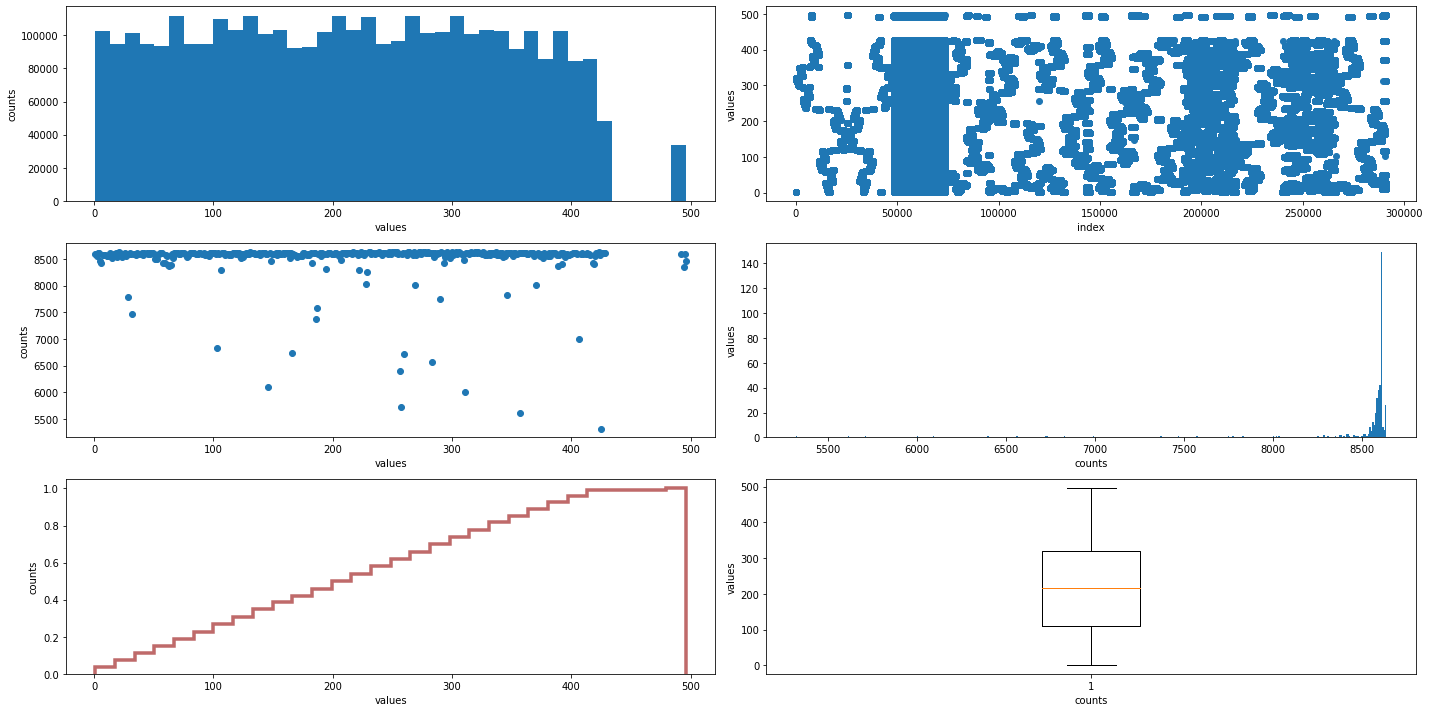

CPU times: user 5.99 s, sys: 1.2 s, total: 7.19 s
Wall time: 7.07 s


In [17]:
%%time

show_counts(data[config_year.year].station_id.compute())

In [18]:
counts = get_column_value_counts(data[config_year.year]['station_id'])
keys = counts.tail(61)
print(keys.keys())

Int64Index([ 79, 171, 125, 285,  78, 343, 170, 395,  23,  19, 294,  66, 376,
             15, 298, 164, 123,  51,  53, 310, 207,   5, 496, 148, 293,  58,
             59,   6, 418, 183, 419, 392,  62,  64,  63, 389, 494, 194, 222,
            106, 229, 228, 269, 370, 346,  28, 290, 187,  32, 186, 406, 103,
            166, 260, 283, 256, 146, 311, 257, 357, 425],
           dtype='int64')


value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 4.82 s, sys: 237 ms, total: 5.06 s
Wall time: 30.4 s


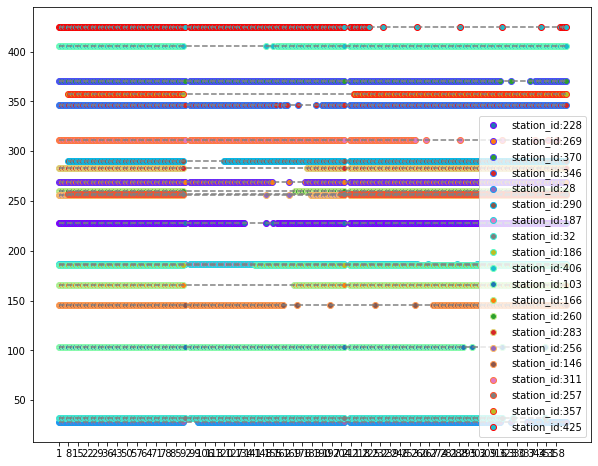

In [19]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofyear', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=np.arange(uniques['dayofyear'].min(),uniques['dayofyear'].max(), 7.0),
    figsize=(10,8),
    count=20
)
# 493, 486, 487, 491, 489, 

value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 4.66 s, sys: 290 ms, total: 4.95 s
Wall time: 30.3 s


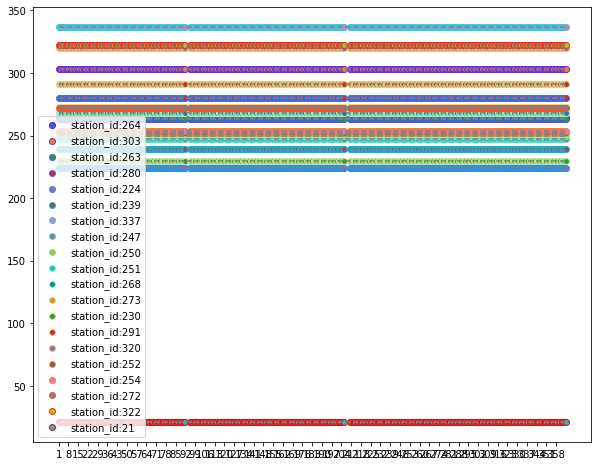

In [20]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofyear', 
    'station_id', 
    'station_id', 
    tail=False, 
    xticks=np.arange(uniques['dayofyear'].min(),uniques['dayofyear'].max(), 7.0),
    figsize=(10,8),
    count=20
)
# 

## 2019 num_bikes_available

In [21]:
%%time

print(stats.describe(data[config_year.year].num_bikes_available))
data[config_year.year].num_bikes_available.describe().compute()

DescribeResult(nobs=3487449, minmax=(-0.16666666666666666, 54.0), mean=9.65643738826675, variance=85.97758139729677, skewness=0.7604582498114639, kurtosis=-0.16715755352806294)
CPU times: user 611 ms, sys: 98.9 ms, total: 710 ms
Wall time: 3.05 s


count    3.487449e+06
mean     9.656437e+00
std      9.272410e+00
min     -1.666667e-01
25%      1.000000e+00
50%      7.200000e+00
75%      1.700000e+01
max      5.400000e+01
Name: num_bikes_available, dtype: float64

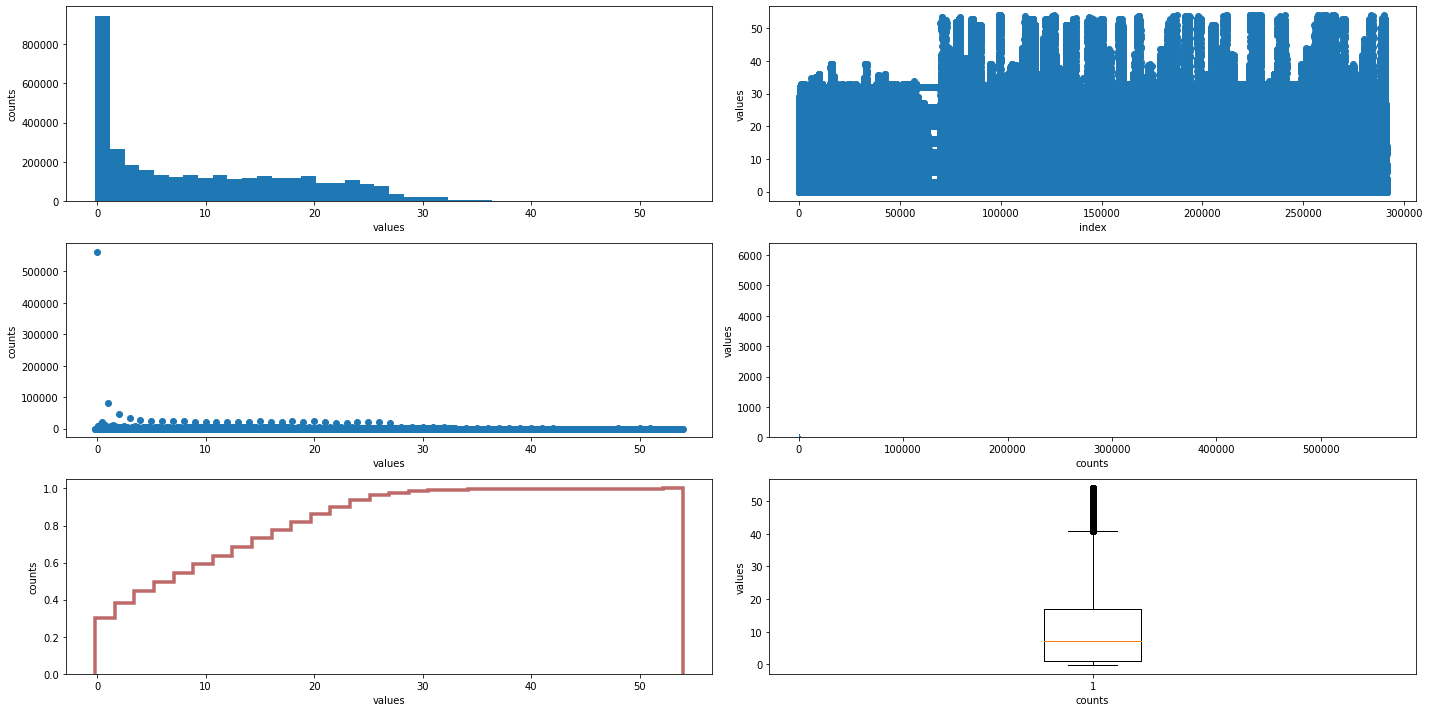

CPU times: user 14.2 s, sys: 2 s, total: 16.2 s
Wall time: 16.8 s


In [22]:
%%time

show_counts(data[config_year.year].num_bikes_available.compute())

344
value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.57 s, sys: 173 ms, total: 1.74 s
Wall time: 8.81 s


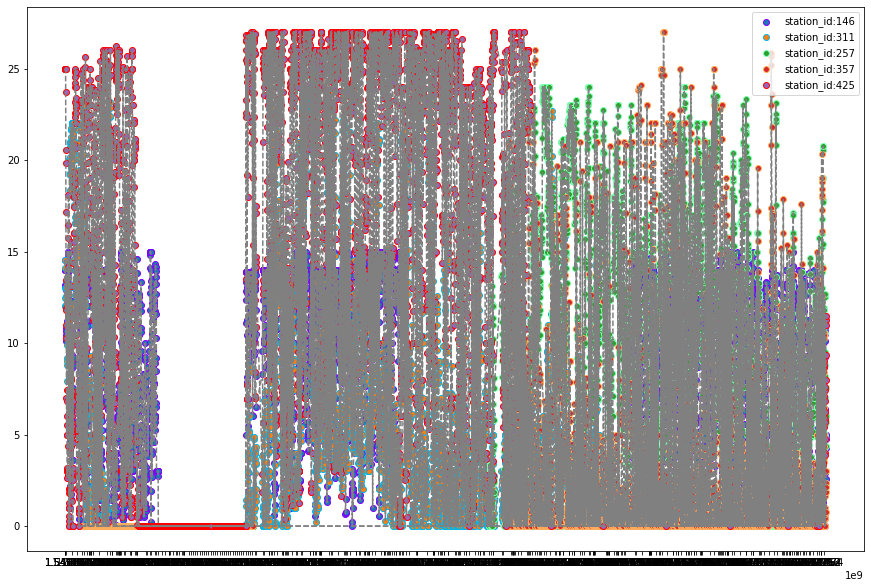

In [23]:
%%time

# Checking availibilty for docks all year
xtikcs_scatter = [uniques['timestamp'][i] for i, x in enumerate(uniques['timestamp']) if i%25==0]
print(len(xtikcs_scatter))

scatter_columns(
    data[config_year.year], 
    'timestamp', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.01 s, sys: 118 ms, total: 2.13 s
Wall time: 9.57 s


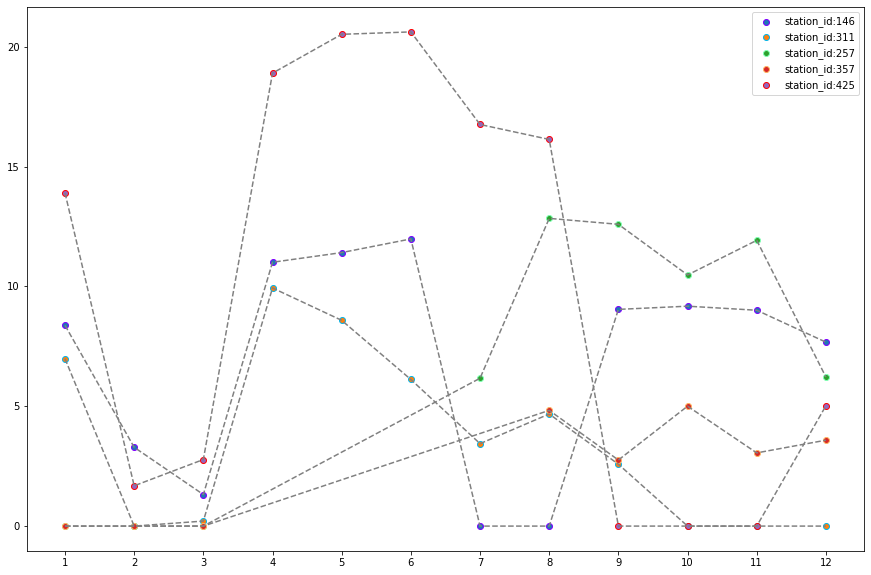

In [24]:
%%time

scatter_columns(
    data[config_year.year], 
    'month', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['month']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.28 s, sys: 161 ms, total: 1.44 s
Wall time: 8.68 s


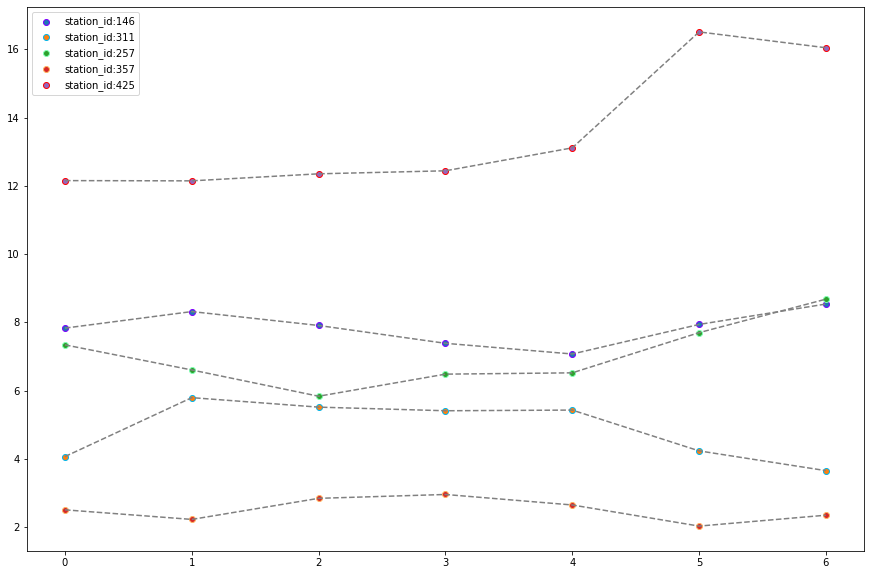

In [25]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofweek', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofweek']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.46 s, sys: 61.9 ms, total: 1.52 s
Wall time: 8.85 s


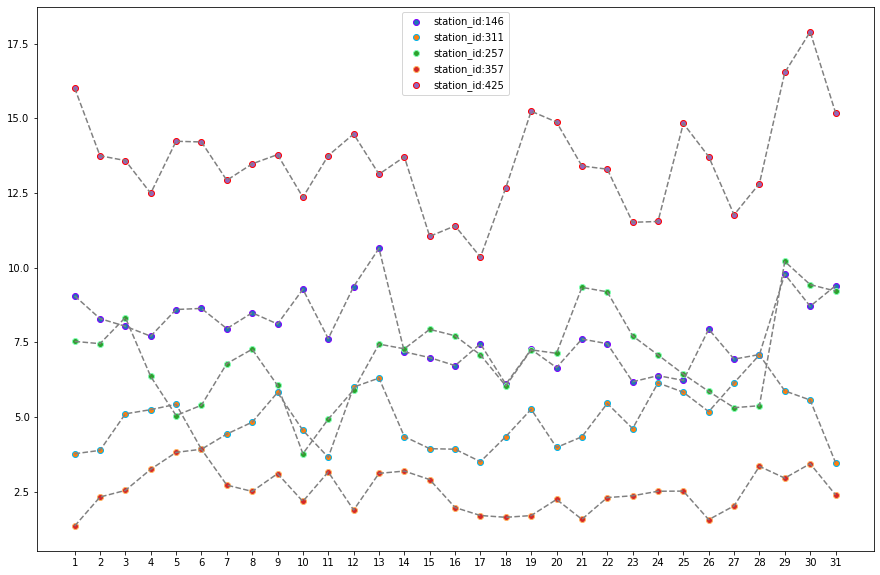

In [26]:
%%time

# mean for all months
scatter_columns(data[config_year.year], 'day', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['day']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 677, 'mean': 677.0, 'median': 677.0, 'std': nan, 'min': 677}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 662, 'mean': 662.0, 'median': 662.0, 'std': nan, 'min': 662}


  0%|          | 0/1 [00:00<?, ?it/s]

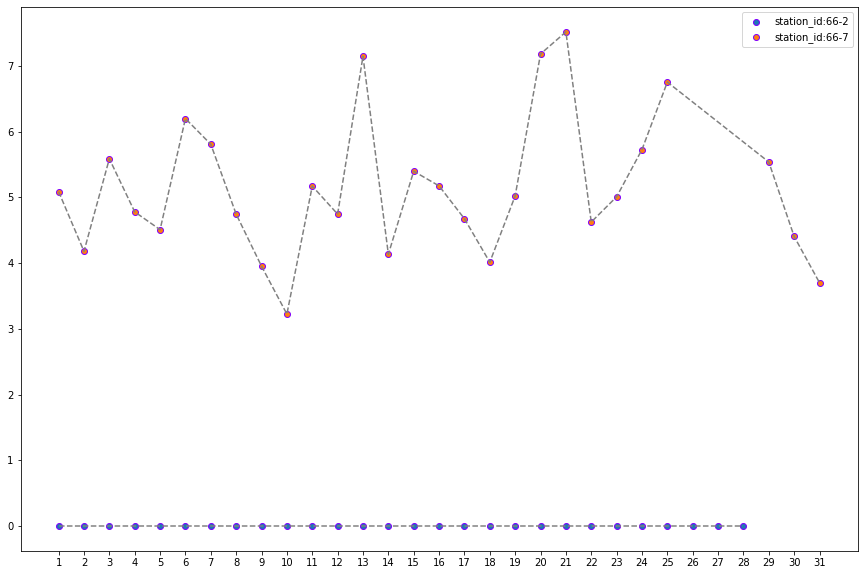

CPU times: user 1.09 s, sys: 119 ms, total: 1.21 s
Wall time: 6.17 s


In [27]:
%%time

station_of_interest = 66

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 677, 'mean': 677.0, 'median': 677.0, 'std': nan, 'min': 677}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 662, 'mean': 662.0, 'median': 662.0, 'std': nan, 'min': 662}


  0%|          | 0/1 [00:00<?, ?it/s]

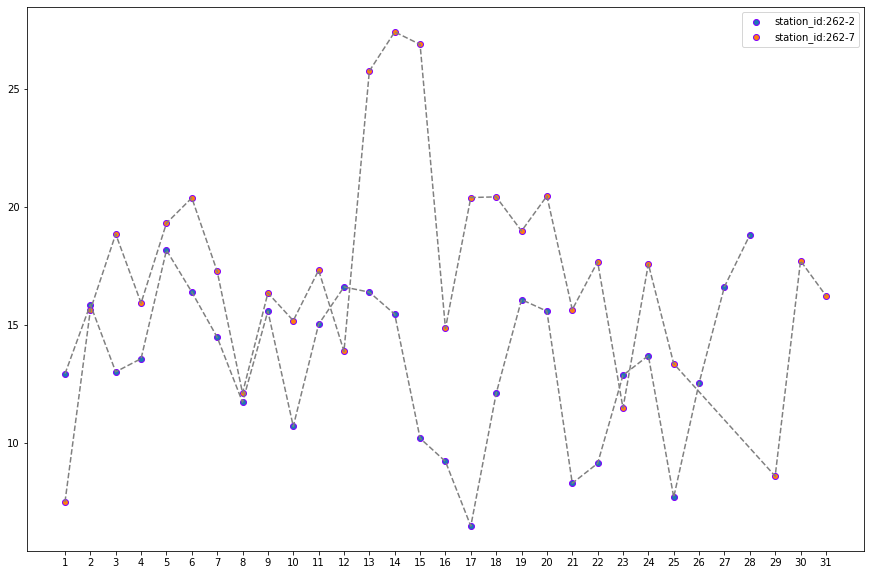

CPU times: user 1.06 s, sys: 106 ms, total: 1.16 s
Wall time: 5.96 s


In [28]:
%%time

station_of_interest = 262

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.27 s, sys: 150 ms, total: 2.42 s
Wall time: 9.5 s


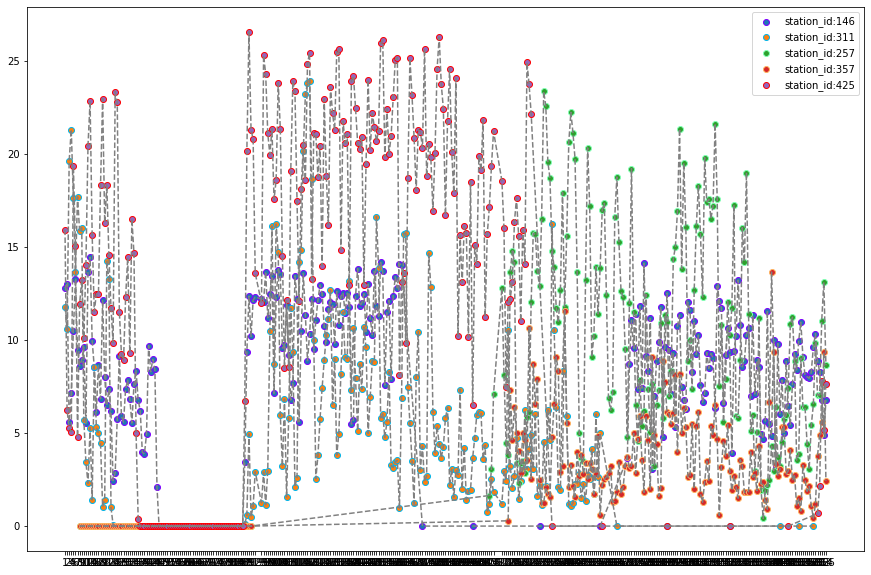

In [29]:
%%time

scatter_columns(data[config_year.year], 'dayofyear', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofyear']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.38 s, sys: 98.1 ms, total: 1.48 s
Wall time: 8.57 s


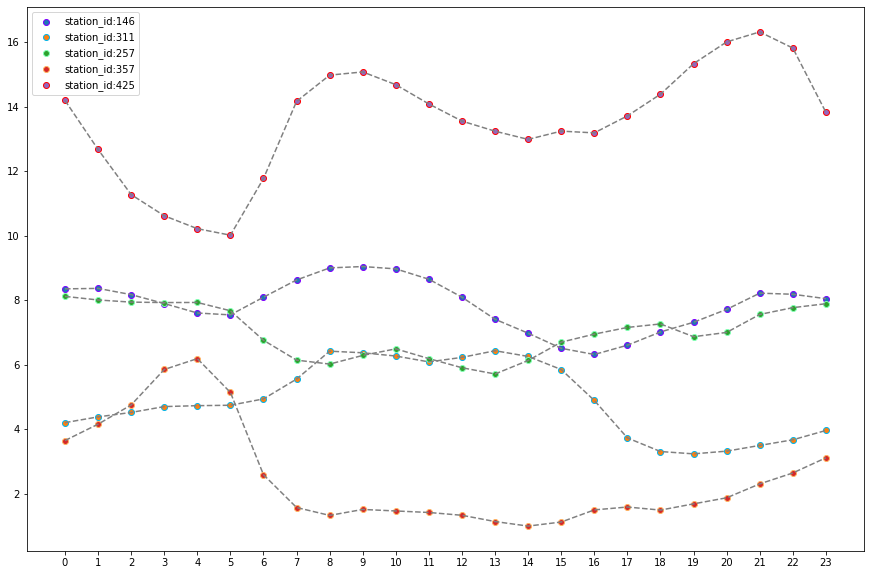

In [30]:
%%time

scatter_columns(data[config_year.year], 'hour', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 24, 'mean': 23.97788697788698, 'median': 24.0, 'std': 0.29277415597412554, 'min': 19}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.31 s, sys: 153 ms, total: 1.46 s
Wall time: 8.64 s


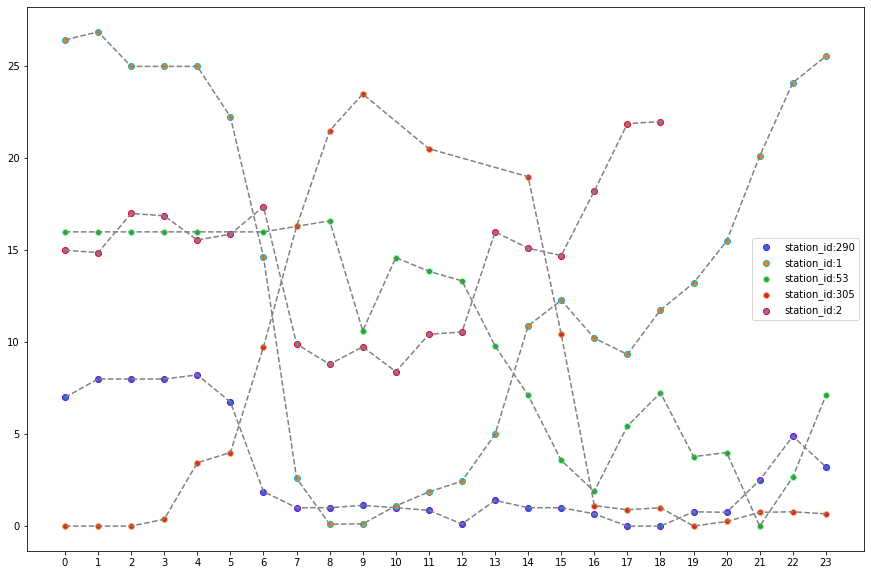

In [31]:
%%time

day_of_interest = 200
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 24, 'mean': 23.623737373737374, 'median': 24.0, 'std': 2.8153902842007215, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.42 s, sys: 118 ms, total: 1.54 s
Wall time: 8.79 s


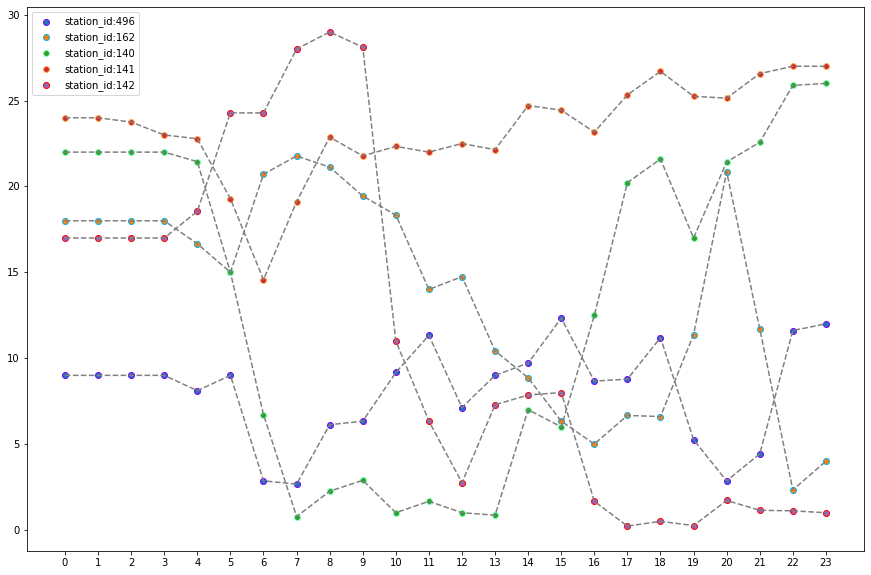

In [32]:
%%time

# https://es.wikipedia.org/wiki/23_de_abril  
# data[config_year.year][data[config_year.year].dayofyear_last_updated_date == 113]

day_of_interest = 113
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'num_bikes_available', 
    'station_id', 
    tail=False,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 1216, 'mean': 1216.0, 'median': 1216.0, 'std': nan, 'min': 1216}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1236, 'mean': 1236.0, 'median': 1236.0, 'std': nan, 'min': 1236}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1187, 'mean': 1187.0, 'median': 1187.0, 'std': nan, 'min': 1187}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1212, 'mean': 1212.0, 'median': 1212.0, 'std': nan, 'min': 1212}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1219, 'mean': 1219.0, 'median': 1219.0, 'std': nan, 'min': 1219}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1229, 'mean': 1229.0, 'median': 1229.0, 'std': nan, 'min': 1229}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1224, 'mean': 1224.0, 'median': 1224.0, 'std': nan, 'min': 1224}


  0%|          | 0/1 [00:00<?, ?it/s]

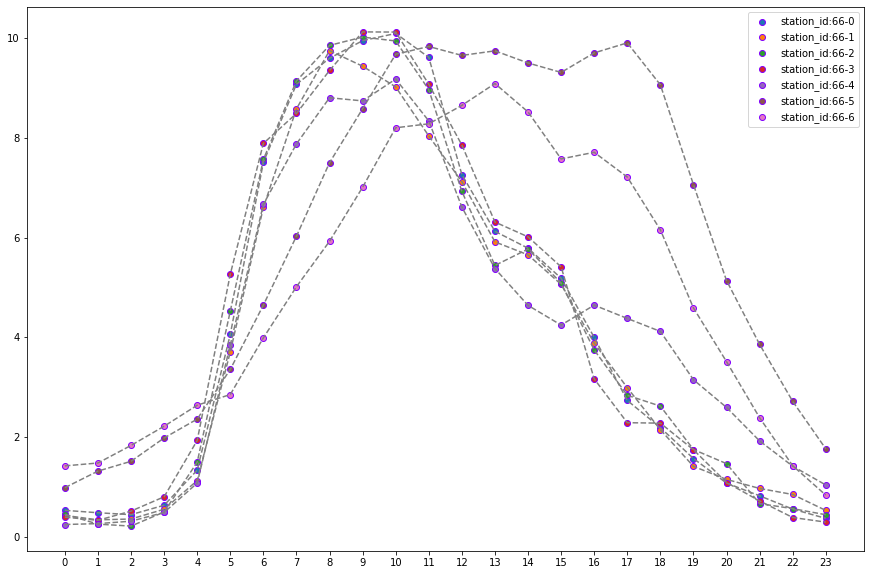

CPU times: user 3.51 s, sys: 252 ms, total: 3.76 s
Wall time: 20.6 s


In [33]:
%%time

station_of_interest = 66

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 1256, 'mean': 1256.0, 'median': 1256.0, 'std': nan, 'min': 1256}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1247, 'mean': 1247.0, 'median': 1247.0, 'std': nan, 'min': 1247}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1203, 'mean': 1203.0, 'median': 1203.0, 'std': nan, 'min': 1203}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1213, 'mean': 1213.0, 'median': 1213.0, 'std': nan, 'min': 1213}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1219, 'mean': 1219.0, 'median': 1219.0, 'std': nan, 'min': 1219}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1217, 'mean': 1217.0, 'median': 1217.0, 'std': nan, 'min': 1217}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1213, 'mean': 1213.0, 'median': 1213.0, 'std': nan, 'min': 1213}


  0%|          | 0/1 [00:00<?, ?it/s]

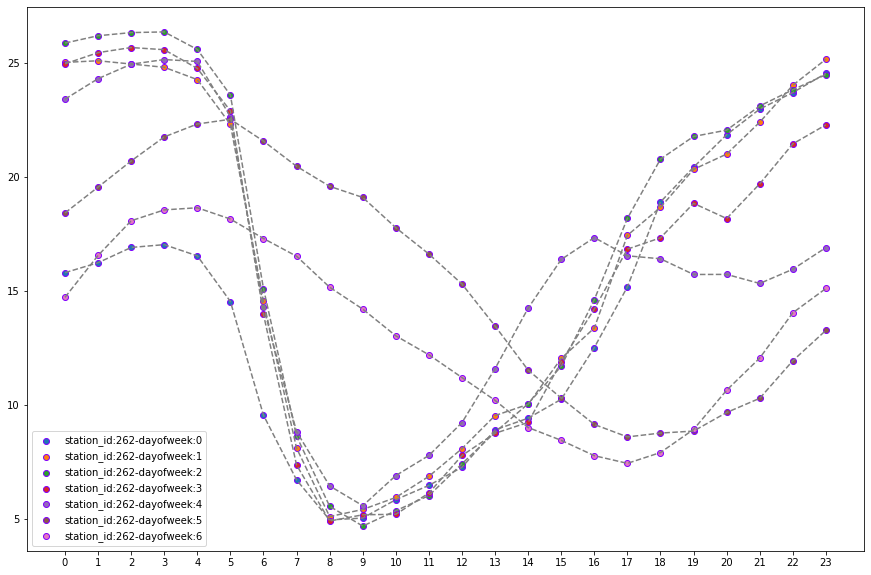

CPU times: user 3.49 s, sys: 358 ms, total: 3.85 s
Wall time: 20.7 s


In [34]:
%%time

station_of_interest = 262

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'dayofweek:{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

## 2019 is_charging_station

In [35]:
%%time

print(stats.describe(data[config_year.year].is_charging_station))
data[config_year.year].is_charging_station.describe().compute()

DescribeResult(nobs=3487449, minmax=(1, 1), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
CPU times: user 600 ms, sys: 60.8 ms, total: 661 ms
Wall time: 3.07 s


count    3487449.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: is_charging_station, dtype: float64

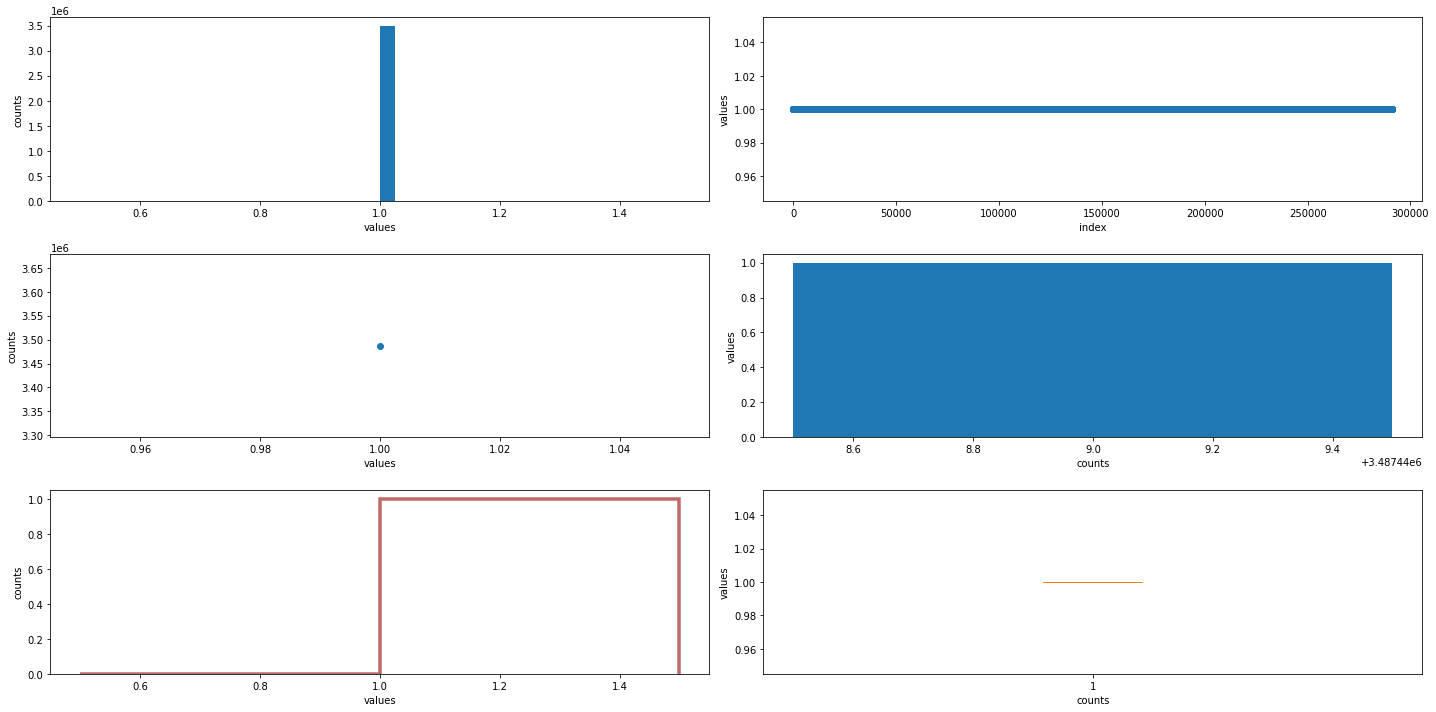

CPU times: user 5.06 s, sys: 265 ms, total: 5.33 s
Wall time: 6.26 s


In [36]:
%%time

show_counts(data[config_year.year].is_charging_station.compute())

## 2019 status

In [37]:
%%time

print(stats.describe(data[config_year.year].status))
data[config_year.year].status.describe().compute()

DescribeResult(nobs=3487449, minmax=(0, 3), mean=0.1291961545530845, variance=0.11294669759198987, skewness=2.2387965190052577, kurtosis=3.203478752519233)
CPU times: user 586 ms, sys: 34.3 ms, total: 620 ms
Wall time: 3.01 s


count    3.487449e+06
mean     1.291962e-01
std      3.360754e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+00
Name: status, dtype: float64

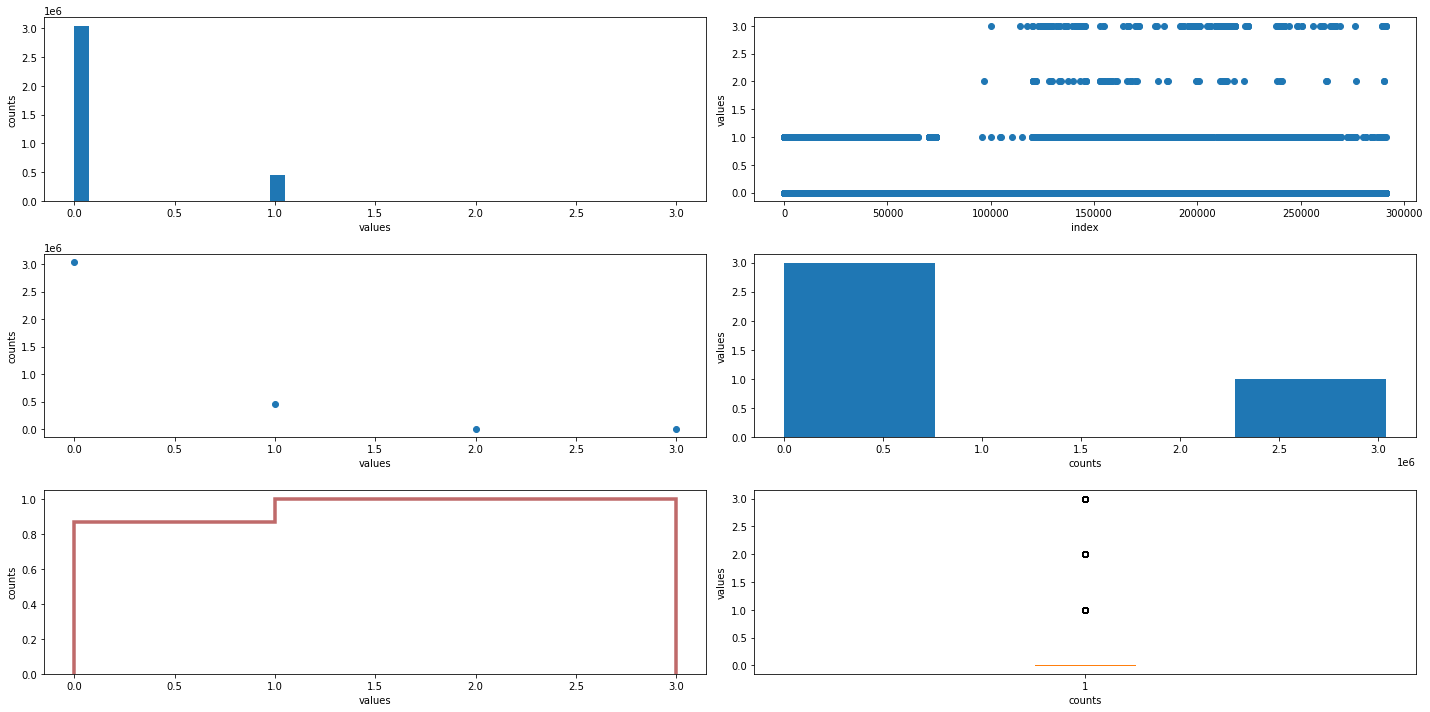

CPU times: user 5.54 s, sys: 314 ms, total: 5.85 s
Wall time: 6.8 s


In [38]:
%%time

show_counts(data[config_year.year].status.compute())

## 2019 is_installed

In [39]:
%%time

print(stats.describe(data[config_year.year].is_installed))
data[config_year.year].is_installed.describe().compute()

DescribeResult(nobs=3487449, minmax=(0, 1), mean=0.999926307166069, variance=7.368742442659469e-05, skewness=-116.47678112235357, kurtosis=13564.840540624582)
CPU times: user 572 ms, sys: 93 ms, total: 666 ms
Wall time: 3.04 s


count    3.487449e+06
mean     9.999263e-01
std      8.584138e-03
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_installed, dtype: float64

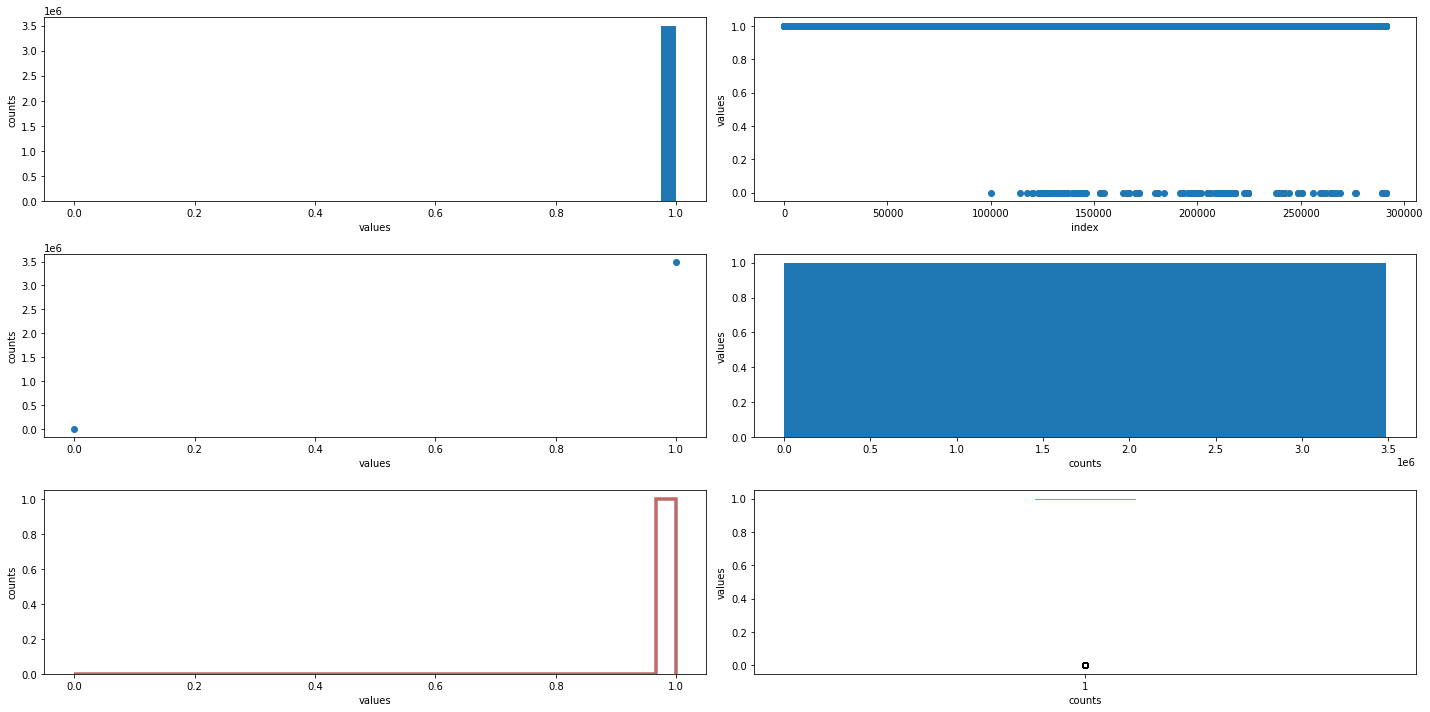

CPU times: user 5.46 s, sys: 339 ms, total: 5.79 s
Wall time: 6.82 s


In [40]:
%%time

show_counts(data[config_year.year].is_installed.compute())

## 2019 is_renting

In [41]:
%%time

print(stats.describe(data[config_year.year].is_renting))
data[config_year.year].is_renting.describe().compute()

DescribeResult(nobs=3487449, minmax=(0, 1), mean=0.999331029643731, variance=0.0006685230266254364, skewness=-38.624282740404446, kurtosis=1489.8352172107197)
CPU times: user 580 ms, sys: 73.4 ms, total: 654 ms
Wall time: 2.97 s


count    3.487449e+06
mean     9.993310e-01
std      2.585581e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_renting, dtype: float64

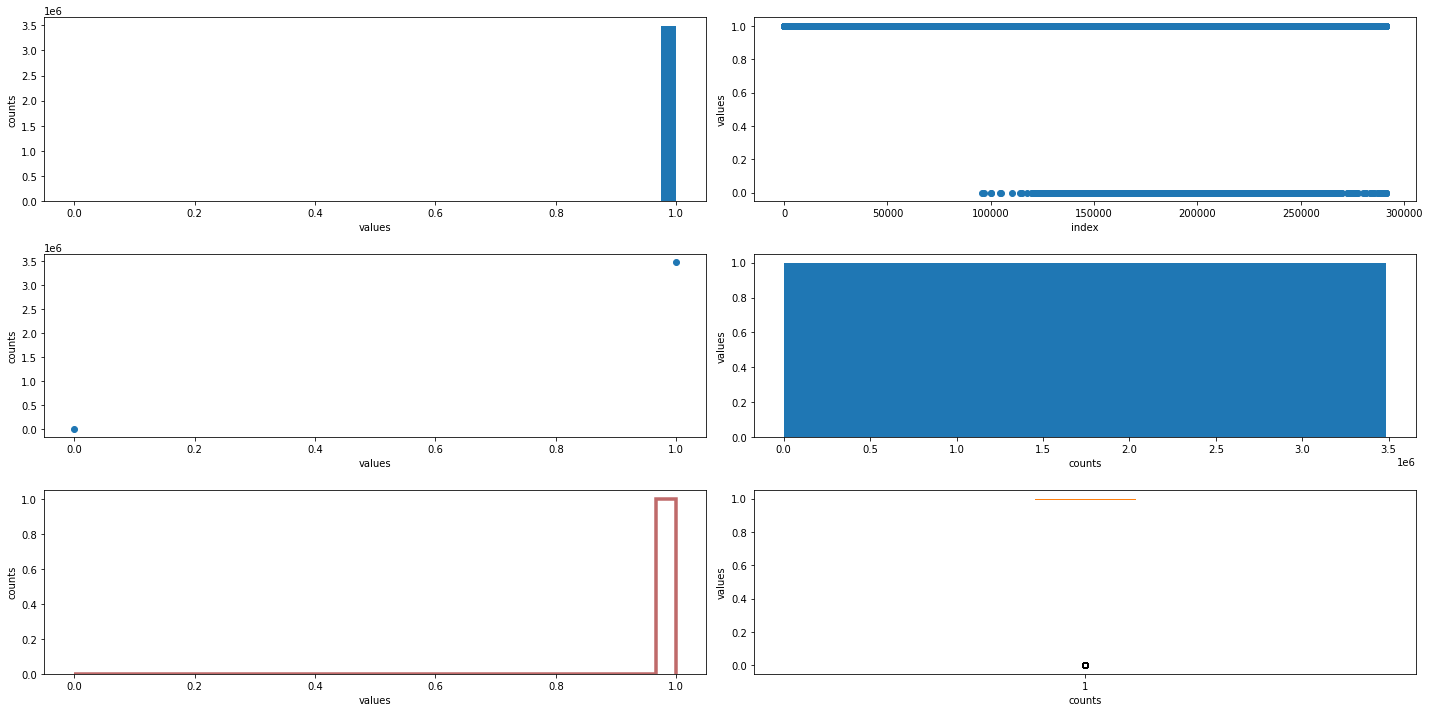

CPU times: user 4.79 s, sys: 392 ms, total: 5.18 s
Wall time: 6.29 s


In [42]:
%%time

show_counts(data[config_year.year].is_renting.compute())

## 2019 is_returning

In [43]:
%%time

print(stats.describe(data[config_year.year].is_returning))
data[config_year.year].is_returning.describe().compute()

DescribeResult(nobs=3487449, minmax=(0, 1), mean=0.9993336103266313, variance=0.0006659457891269211, skewness=-38.699149355120596, kurtosis=1495.6241608099326)
CPU times: user 639 ms, sys: 22.6 ms, total: 661 ms
Wall time: 3.04 s


count    3.487449e+06
mean     9.993336e-01
std      2.580593e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_returning, dtype: float64

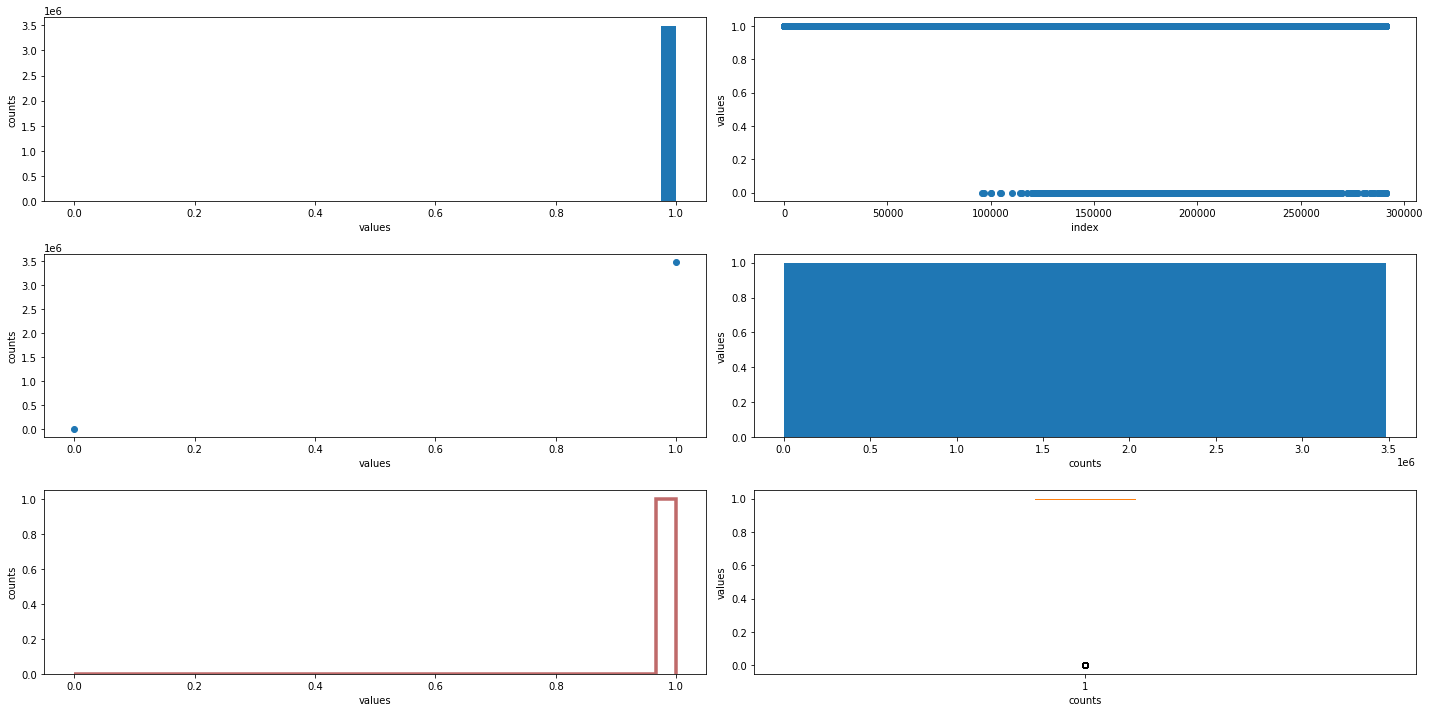

CPU times: user 5.2 s, sys: 283 ms, total: 5.48 s
Wall time: 6.42 s


In [44]:
%%time

show_counts(data[config_year.year].is_returning.compute())

## 2019 ctx0

In [45]:
%%time

print(stats.describe(data[config_year.year].ctx0))
data[config_year.year].ctx0.describe().compute()

DescribeResult(nobs=3487449, minmax=(0.0, 1.0), mean=0.5808100951190068, variance=0.11017080025059732, skewness=-0.35357583542889953, kurtosis=-1.2813654832183228)
CPU times: user 580 ms, sys: 42.7 ms, total: 623 ms
Wall time: 2.98 s


count    3.487449e+06
mean     5.808101e-01
std      3.319199e-01
min      0.000000e+00
25%      2.857143e-01
50%      6.477273e-01
75%      8.919753e-01
max      1.000000e+00
Name: ctx0, dtype: float64

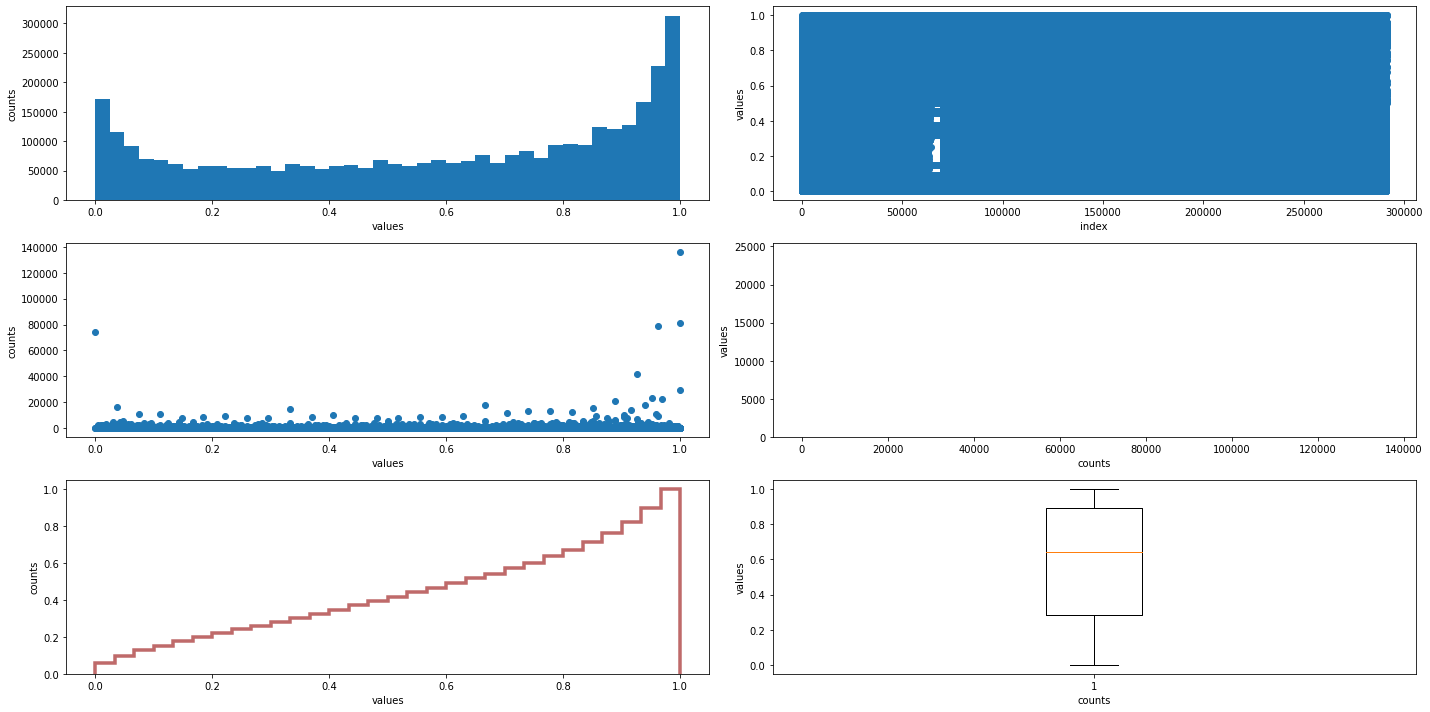

CPU times: user 1min 19s, sys: 13.6 s, total: 1min 33s
Wall time: 1min 31s


In [46]:
%%time

show_counts(data[config_year.year].ctx0.compute())

344
value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 693 ms, sys: 89.9 ms, total: 783 ms
Wall time: 3.16 s


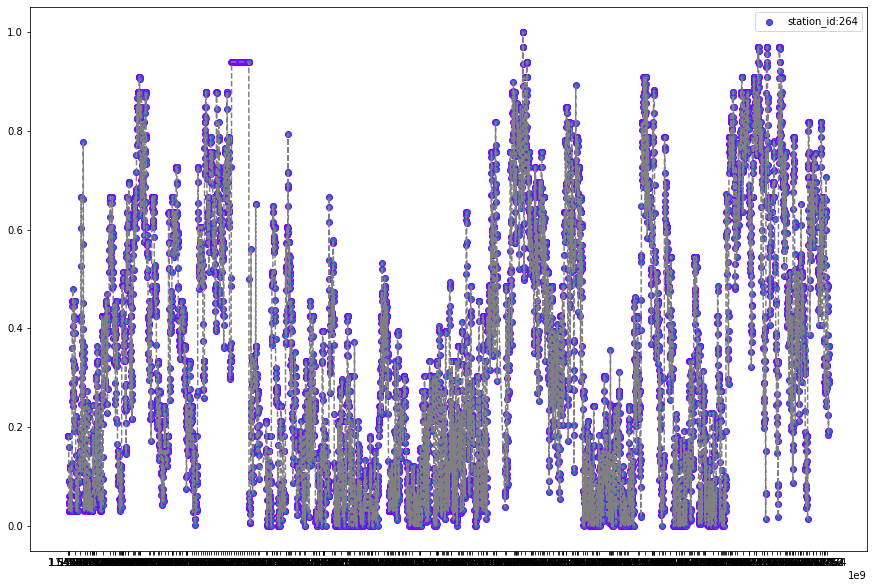

In [47]:
%%time

# Checking availibilty for docks all year
xtikcs_scatter = [uniques['timestamp'][i] for i, x in enumerate(uniques['timestamp']) if i%25==0]
print(len(xtikcs_scatter))

scatter_columns(
    data[config_year.year], 
    'timestamp', 
    'ctx0', 
    'station_id', 
    tail=False,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=1
)


value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 5.18 s, sys: 143 ms, total: 5.32 s
Wall time: 12.8 s


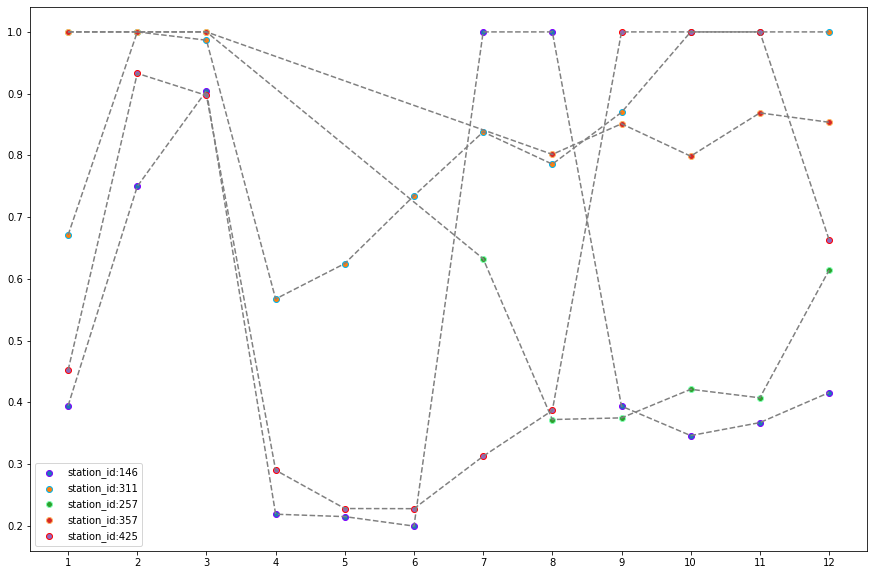

In [48]:
%%time

scatter_columns(
    data[config_year.year], 
    'month', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['month']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.35 s, sys: 68.4 ms, total: 1.42 s
Wall time: 8.47 s


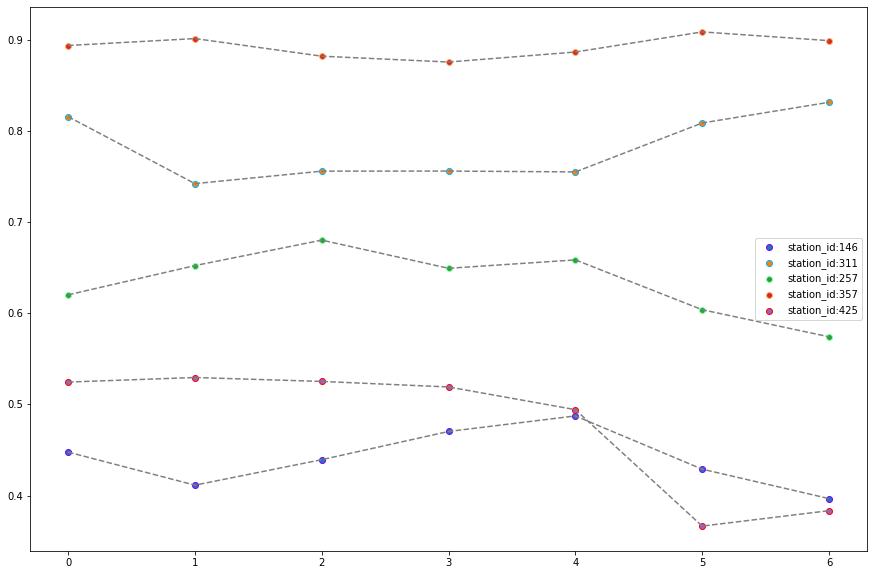

In [49]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofweek', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofweek']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.39 s, sys: 161 ms, total: 1.56 s
Wall time: 8.69 s


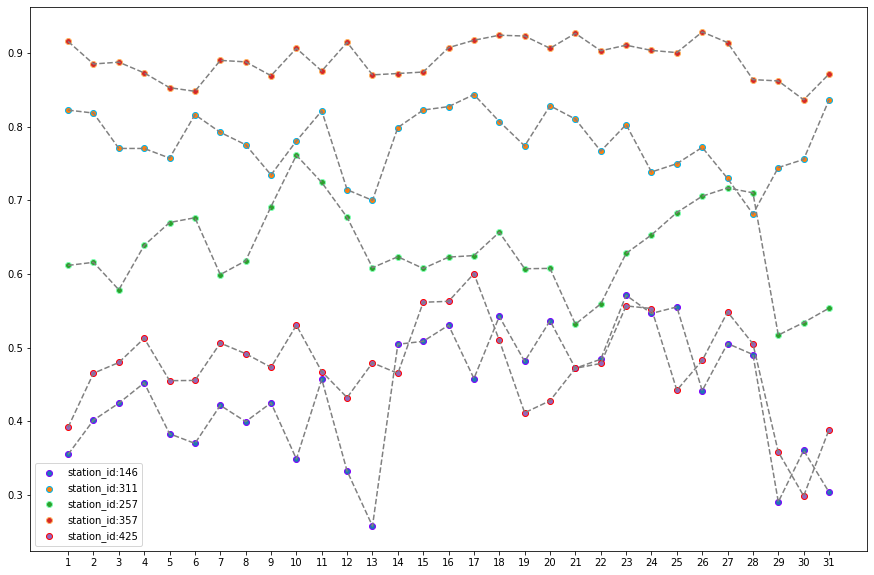

In [50]:
%%time

# mean for all months
scatter_columns(data[config_year.year], 'day', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['day']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 677, 'mean': 677.0, 'median': 677.0, 'std': nan, 'min': 677}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 662, 'mean': 662.0, 'median': 662.0, 'std': nan, 'min': 662}


  0%|          | 0/1 [00:00<?, ?it/s]

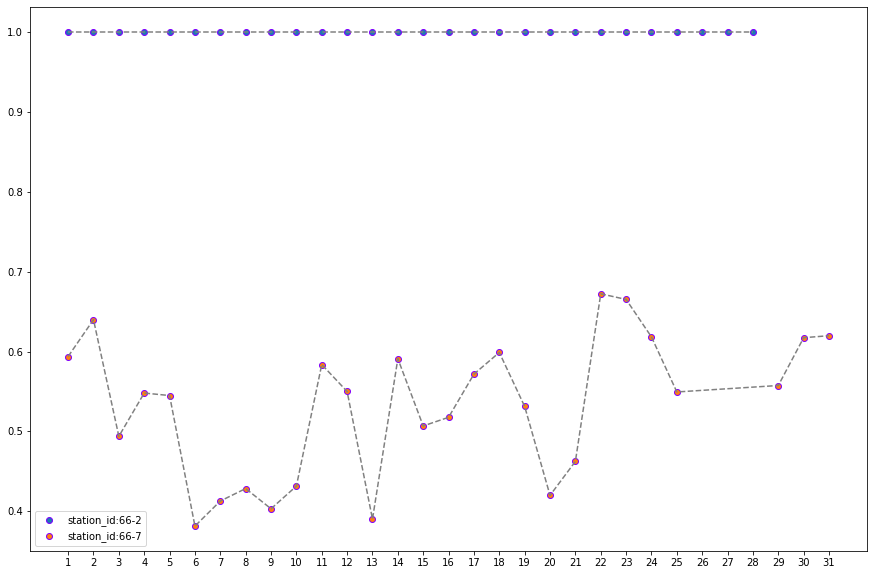

CPU times: user 1.45 s, sys: 179 ms, total: 1.63 s
Wall time: 7.21 s


In [51]:
%%time

station_of_interest = 66

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 677, 'mean': 677.0, 'median': 677.0, 'std': nan, 'min': 677}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 662, 'mean': 662.0, 'median': 662.0, 'std': nan, 'min': 662}


  0%|          | 0/1 [00:00<?, ?it/s]

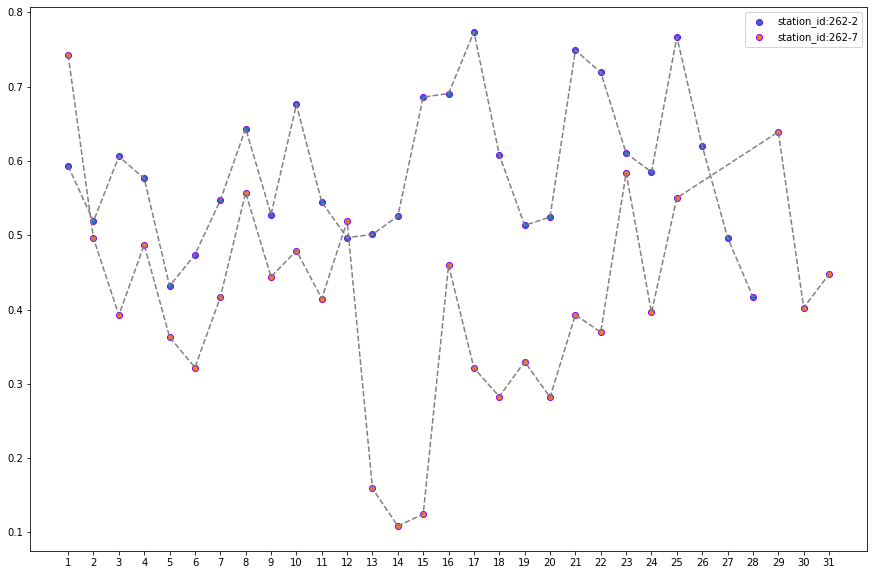

CPU times: user 1.34 s, sys: 150 ms, total: 1.49 s
Wall time: 6.95 s


In [52]:
%%time

station_of_interest = 262

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.78 s, sys: 96.3 ms, total: 1.88 s
Wall time: 9.53 s


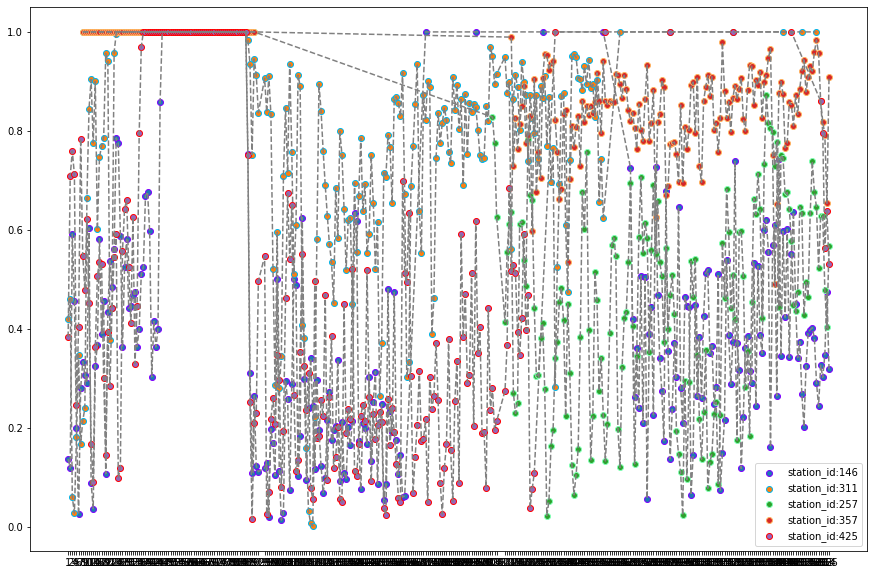

In [53]:
%%time

scatter_columns(data[config_year.year], 'dayofyear', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofyear']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8638, 'mean': 8505.973170731708, 'median': 8602.0, 'std': 405.20478297873797, 'min': 5321}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.67 s, sys: 47.2 ms, total: 1.72 s
Wall time: 9.42 s


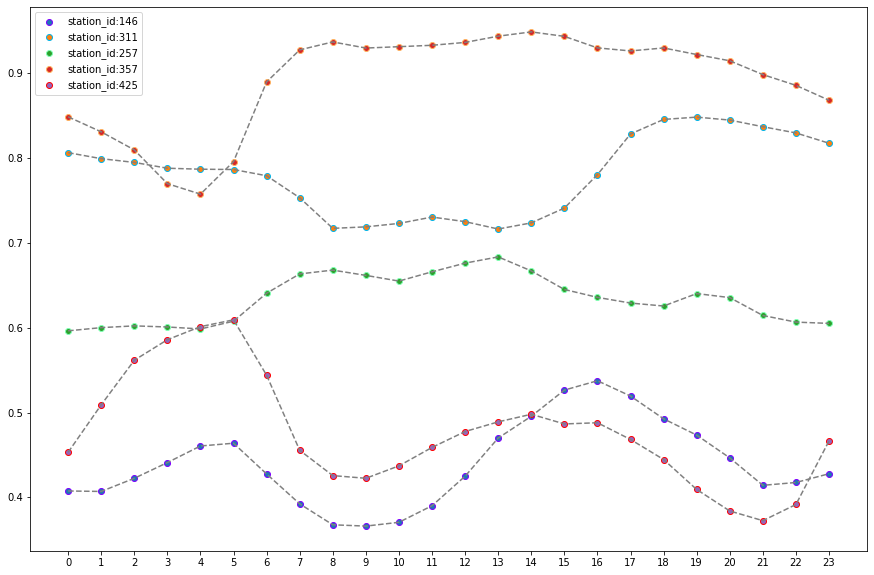

In [54]:
%%time

scatter_columns(data[config_year.year], 'hour', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 24, 'mean': 23.97788697788698, 'median': 24.0, 'std': 0.29277415597412554, 'min': 19}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.58 s, sys: 166 ms, total: 1.75 s
Wall time: 9.54 s


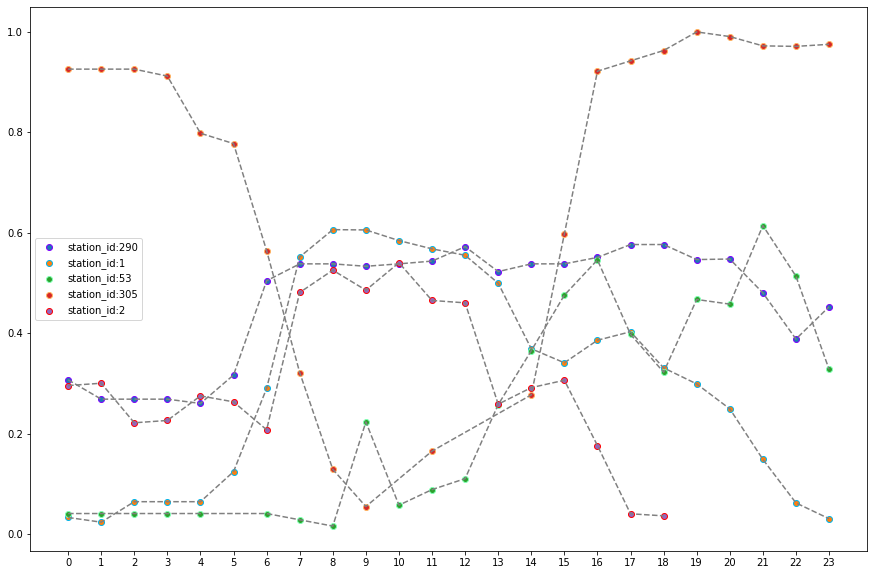

In [55]:
%%time

day_of_interest = 200
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 24, 'mean': 23.623737373737374, 'median': 24.0, 'std': 2.8153902842007215, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.54 s, sys: 93.1 ms, total: 1.64 s
Wall time: 9.21 s


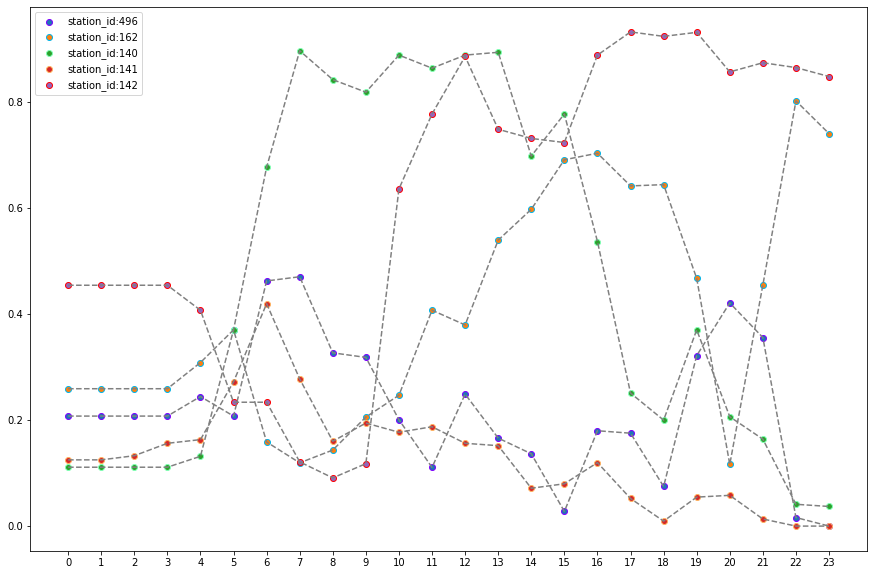

In [56]:
%%time

# https://es.wikipedia.org/wiki/23_de_abril  
# data[config_year.year][data[config_year.year].dayofyear_last_updated_date == 113]

day_of_interest = 113
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'ctx0', 
    'station_id', 
    tail=False,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 1216, 'mean': 1216.0, 'median': 1216.0, 'std': nan, 'min': 1216}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1236, 'mean': 1236.0, 'median': 1236.0, 'std': nan, 'min': 1236}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1187, 'mean': 1187.0, 'median': 1187.0, 'std': nan, 'min': 1187}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1212, 'mean': 1212.0, 'median': 1212.0, 'std': nan, 'min': 1212}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1219, 'mean': 1219.0, 'median': 1219.0, 'std': nan, 'min': 1219}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1229, 'mean': 1229.0, 'median': 1229.0, 'std': nan, 'min': 1229}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1224, 'mean': 1224.0, 'median': 1224.0, 'std': nan, 'min': 1224}


  0%|          | 0/1 [00:00<?, ?it/s]

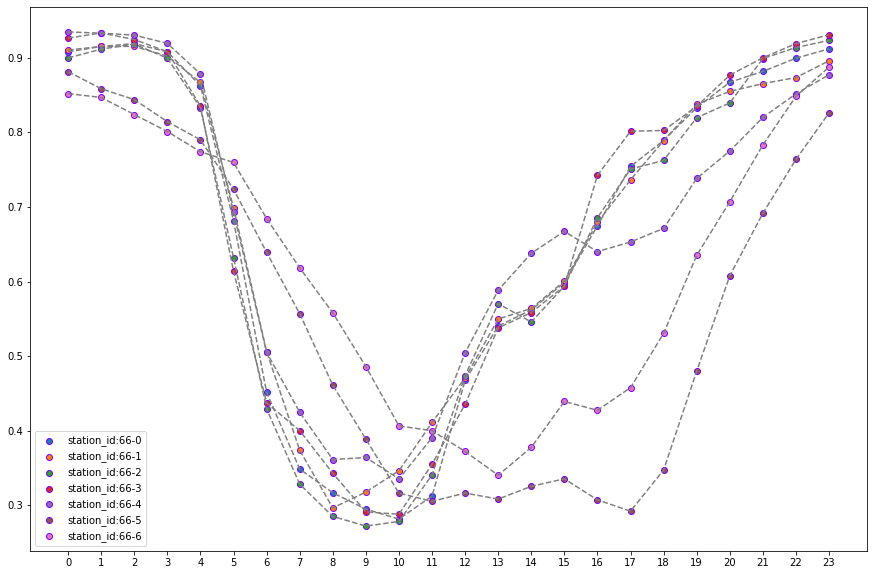

CPU times: user 3.39 s, sys: 306 ms, total: 3.7 s
Wall time: 20.6 s


In [57]:
%%time

station_of_interest = 66

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 1256, 'mean': 1256.0, 'median': 1256.0, 'std': nan, 'min': 1256}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1247, 'mean': 1247.0, 'median': 1247.0, 'std': nan, 'min': 1247}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1203, 'mean': 1203.0, 'median': 1203.0, 'std': nan, 'min': 1203}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1213, 'mean': 1213.0, 'median': 1213.0, 'std': nan, 'min': 1213}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1219, 'mean': 1219.0, 'median': 1219.0, 'std': nan, 'min': 1219}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1217, 'mean': 1217.0, 'median': 1217.0, 'std': nan, 'min': 1217}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1213, 'mean': 1213.0, 'median': 1213.0, 'std': nan, 'min': 1213}


  0%|          | 0/1 [00:00<?, ?it/s]

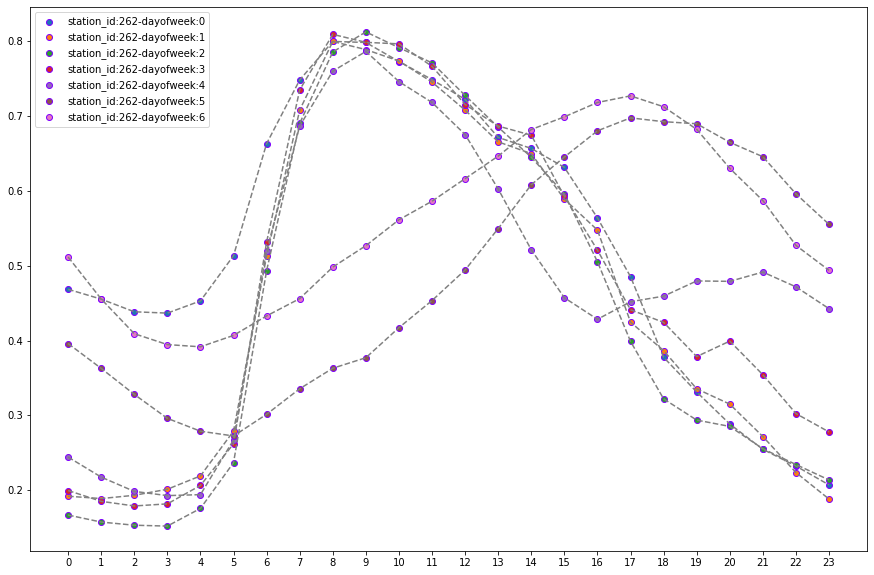

CPU times: user 3.78 s, sys: 353 ms, total: 4.13 s
Wall time: 21.5 s


In [58]:
%%time

station_of_interest = 262

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'dayofweek:{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()